# NDWI-tide correlation tide model rankings

This code processes correlations between multiple global ocean tide models and satellite-derived NDWI water index data at regularly spaced points along the coastline, and returns tide model performance and rankings in a standardised format for further analysis.

## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ../..

/home/jovyan/Robbi/dea-intertidal


Install additional packages directly from the requirements file:

In [ ]:
pip install -r requirements.in --quiet

Now restart!

### Load packages

In [3]:
%load_ext autoreload
%autoreload 2

import os

import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from ipyleaflet import basemaps, basemap_to_tiles

import datacube
import odc.geo.xr
from odc.geo.geom import Geometry
from odc.geo.geobox import GeoBox
from odc.ui import select_on_a_map

from dea_tools.dask import create_local_dask_cluster
from dea_tools.coastal import pixel_tides, tidal_tag, model_tides
from intertidal.elevation import (
    load_data,
    ds_to_flat,
    flat_to_ds,
)

def correlation_loop(point_id, geom, models):
    satellite_ds, _, _ = load_data(
        dc=dc,
        study_area=point_id,
        geom=geom,
        time_range=(start_date, end_date),
        resolution=resolution,
        crs=crs,
        include_s2=True,
        include_ls=True,
        filter_gqa=filter_gqa,
        dask_chunks={"x": None, "y": None},
    )

    # Load data
    satellite_ds.load()

    # Model tides
    tides_df = model_tides(
        x=satellite_ds.x.mean(),
        y=satellite_ds.y.mean(),
        time=satellite_ds.time,
        model=models,
        directory=tide_model_dir,
        crs=satellite_ds.odc.crs,
        parallel_splits=1,
    )

    # Add to data
    satellite_ds["tide_m"] = (
        tides_df.droplevel(level=["x", "y"])
        .set_index("tide_model", append=True)
        .to_xarray()
        .tide_m.reindex_like(satellite_ds)
        .transpose("tide_model", "time")
    )

    # Calculate corrs
    _, _, corr = ds_to_flat(
        satellite_ds,
        ndwi_thresh=0.0,
        min_freq=0.01,
        max_freq=0.99,
    )

    corr_mask = corr.max(dim="tide_model") >= 0.15
    corr = corr.where(corr_mask)

    out_df = (
        corr.drop("spatial_ref")
        .mean(dim="z")
        .to_dataframe(name="tide_m")
        .assign(point_id=point_id)
        .set_index("point_id", append=True)
    )

    # Add percent valid intertidal pixels analysed
    out_df["valid_perc"] = corr_mask.mean(dim="z").item()

    return out_df


## Setup


### Set analysis parameters

In [3]:
# Intertidal Elevation variables
start_date = "2017"  # Informed by http://www.bom.gov.au/climate/enso/soi/?
end_date = "2019"  #  Non La Nina/El Nino period
resolution = 10  # Spatial resolution used for output files
crs = "EPSG:3577"  # Coordinate Reference System (CRS) to use for output files
include_s2 = True  # Include Sentinel-2 data in the analysis?
include_ls = True  # Include Landsat data in the analysis?
filter_gqa = True  # Filter to remove poorly georeferenced scenes?
tide_model_dir = "/gdata1/data/tide_models_clipped/"  # Directory containing tide model files

# Models to run
models = [
    "FES2022",
    "FES2014",
    "TPXO9-atlas-v5",
    "EOT20",
    "HAMTIDE11",
    "GOT4.10",
    "FES2012",
    "TPXO8-atlas-v1",
]

### Load correlation points

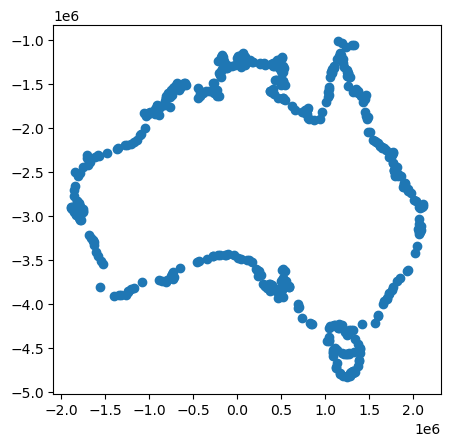

In [4]:
# Load points
points_gdf = gpd.read_file("data/raw/tide_correlation_points_input.geojson").to_crs("EPSG:3577")

# Select subset
# points_gdf, name = points_gdf.iloc[0:2], "test"
# points_gdf, name = points_gdf.to_crs("EPSG:4326").cx[149.249485:150.307278, -22.739863:-21.483880].to_crs("EPSG:3577"), "test"
# points_gdf, name = points_gdf.iloc[0:500], "robbi_part1"
points_gdf, name = points_gdf.iloc[500:1000], "robbi_part2"
# points_gdf, name = points_gdf.iloc[1000:1500], "claire_part1"
# points_gdf, name = points_gdf.iloc[1500:2000], "claire_part2"
# points_gdf, name = points_gdf.iloc[2000:2500], "ness_part1"
# points_gdf, name = points_gdf.iloc[2500:3000], "ness_part2"
points_gdf.plot()

# Apply buffer
points_gdf["geometry"] = points_gdf.geometry.buffer(2500)


## Run correlation analysis

In [ ]:
# Connect to datacube
dc = datacube.Datacube(app="NDWI-tide correlations")

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

out_list = []

for i, row in tqdm(points_gdf.iterrows(), 
                   total=points_gdf.shape[0]):
    
    try:
    
        point_id = row.id
        print(f"Processing ID {point_id}")
        geom = Geometry(row.geometry, crs="EPSG:3577")       

        output_df = correlation_loop(point_id, geom, models)
        output_df["x"] = row.geometry.centroid.x
        output_df["y"] = row.geometry.centroid.y

        out_list.append(output_df)

        client.restart()
    
    except:
        print(f"{point_id} failed; skipping")
    
client.close()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 31,Total memory: 237.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43263,Workers: 1
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Total threads: 31
Started: Just now,Total memory: 237.21 GiB
Comm: tcp://127.0.0.1:45283,Total threads: 31
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/42037/status,Memory: 237.21 GiB
Nanny: tcp://127.0.0.1:43197,


  0%|          | 0/500 [00:00<?, ?it/s]

Processing ID 500


/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Modelling tides using FES2022, FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel



100%|██████████| 8/8 [00:14<00:00,  1.83s/it]


### Combine and process data

In [ ]:
# Combine outputs into single dataframe
combined_df = (
    pd.concat(out_list)
    .set_index(["x", "y", "valid_perc"], append=True)
    .unstack("tide_model")["tide_m"]
    .assign(source="ndwi correlation", statistic="correlation")
    .reset_index(["x", "y", "valid_perc"])
    .reindex(["x", "y", "valid_perc", "source", "statistic"] + models, axis=1)
)

# Add additional columns
combined_df["min"] = combined_df.loc[:, models].min(axis=1)
combined_df["max"] = combined_df.loc[:, models].max(axis=1)
combined_df["diff"] = combined_df["max"] - combined_df["min"]
combined_df["ave"] = combined_df.loc[:, models].mean(axis=1)
combined_df["std"] = combined_df.loc[:, models].std(axis=1)
combined_df["missing"] = combined_df.loc[:, models].isna().sum(axis=1)

# Calculate ranks and best/worst models
combined_df = pd.concat(
    [combined_df, combined_df.loc[:, models].rank(axis=1, ascending=False).add_prefix("rank_")], axis=1
)
combined_df["top_model"] = combined_df.filter(regex='^rank').idxmin(axis=1).str[5:]
combined_df["worst_model"] = combined_df.filter(regex='^rank').idxmax(axis=1).str[5:]
combined_df

### Export

In [ ]:
combined_gdf = gpd.GeoDataFrame(
    data=combined_df,
    geometry=gpd.points_from_xy(combined_df.x, combined_df.y, crs="EPSG:3577"),
).to_crs("EPSG:4326")
combined_gdf.to_file(f"data/raw/tide_correlation_points_{name}.geojson")
combined_gdf.explore()

### Combine

In [4]:
tide_correlation_points = pd.concat(
    [
        gpd.read_file("data/raw/tide_correlation_points_robbi_part1.geojson"),
        gpd.read_file("data/raw/tide_correlation_points_robbi_part2.geojson"),
        gpd.read_file("data/raw/tide_correlation_points_ness_part1.geojson"),
        gpd.read_file("data/raw/tide_correlation_points_ness_part2.geojson"),
        gpd.read_file("data/raw/tide_correlation_points_claire_part1.geojson"),
        gpd.read_file("data/raw/tide_correlation_points_claire_part2.geojson")
    ]
).dropna(subset="FES2014")

# Convert x/y to lat/lon
tide_correlation_points["x"] = tide_correlation_points.geometry.x
tide_correlation_points["y"] = tide_correlation_points.geometry.y

# Export
tide_correlation_points.to_file(f"data/raw/rankings_correlations_2017-2019.geojson")

#### Combine with altimetry

In [5]:
import geopandas as gpd
tide_correlation_points = gpd.read_file("data/raw/rankings_correlations_2017-2019.geojson")
coastal_altimetry_points = gpd.read_file("data/raw/rankings_altimetry_2017-2019.geojson")

In [6]:
import pandas as pd

rank_cols = [
    "rank_FES2022",
    "rank_FES2014",
    "rank_TPXO9-atlas-v5",
    "rank_EOT20",
    "rank_HAMTIDE11",
    "rank_GOT4.10",
    "rank_FES2012",
    "rank_TPXO8-atlas-v1",
]

value_cols = [
    "FES2022",
    "FES2014",
    "TPXO9-atlas-v5",
    "EOT20",
    "HAMTIDE11",
    "GOT4.10",
    "FES2012",
    "TPXO8-atlas-v1",
]


combined_gdf = (
    pd.concat([tide_correlation_points, coastal_altimetry_points])
    .drop("point_id", axis=1)
    .rename_axis("point_id")
    .dropna(subset=rank_cols)
)

# Convert dtypes
combined_gdf[rank_cols] = combined_gdf[rank_cols].astype('int16')
float64_cols = list(combined_gdf.select_dtypes(include='float64'))
combined_gdf[float64_cols] = combined_gdf[float64_cols].round(3).astype('float32')

combined_gdf.to_file(f"data/raw/rankings_ensemble_2017-2019.geojson")

In [7]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(combined_gdf)


,x,y,valid_perc,source,statistic,FES2022,FES2014,TPXO9-atlas-v5,EOT20,HAMTIDE11,GOT4.10,FES2012,TPXO8-atlas-v1,min,max,diff,ave,std,missing,rank_FES2022,rank_FES2014,rank_TPXO9-atlas-v5,rank_EOT20,rank_HAMTIDE11,rank_GOT4.10,rank_FES2012,rank_TPXO8-atlas-v1,top_model,worst_model,geometry
point_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,136.774994,-14.176000,0.170,ndwi correlation,correlation,0.210,0.199,0.208,0.222,0.216,0.216,0.206,0.213,0.199,0.222,0.023,0.211,0.007,0,5,8,6,1,3,2,7,4,EOT20,FES2014,POINT (136.77480 -14.17637)
1,143.264999,-11.806000,0.036,ndwi correlation,correlation,0.156,0.142,0.164,0.142,0.134,0.105,0.138,0.094,0.094,0.164,0.070,0.134,0.024,0,2,3,1,4,6,7,5,8,TPXO9-atlas-v5,TPXO8-atlas-v1,POINT (143.26482 -11.80643)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42381,157.044998,-32.870998,1.000,x-track altimetry (TP+J1+J2+J3),rms,0.296,0.296,0.296,0.287,0.295,0.296,0.293,0.294,0.287,0.296,0.009,0.294,0.003,0,6,7,8,1,4,5,2,3,EOT20,TPXO9-atlas-v5,POINT (157.04482 -32.87098)
42382,157.044998,-39.790001,1.000,x-track altimetry (S3A),rms,0.094,0.096,0.095,0.094,0.101,0.098,0.098,0.098,0.094,0.101,0.007,0.097,0.002,0,1,4,3,2,8,7,6,5,FES2022,HAMTIDE11,POINT (157.04487 -39.78957)
